# ID control selection
This notebook selects fitting ID controls to the KdV patients


In [1]:
import pandas as pd
import os
import os.path
from os import listdir
from os.path import isfile, join
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import openpyxl


In [2]:
# CHANGE THIS CELL (including both)
#lowest_age = 13
#highest_age = 40

In [36]:
# open KdV excel sheet
#kdv_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-patients\DatabasePatients_edit_nov_2017.xlsx"
syndrome_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\adnp\ADNP_Database.xlsx"

assert os.path.exists(syndrome_file), "This path doesn't exist."

# ### 2 blocks below were necessary as there was an extra row at the beginning of the xlsx file ###
# # open the xlsx file
# xlsx = openpyxl.load_workbook(syndrome_file)
# sheet = xlsx.active
# data = sheet.rows

# # write data to 2d list
# data_list = []
# for row in data:
#     column = []
#     l = list(row)
#     for i in range(len(l)):
#         column.append(l[i].value)
#     data_list.append(column)
    
# data_list = np.array(data_list)
# data = data_list[1:, :]

# # transform list into dataframe
# df_syn = pd.DataFrame(data[1:],columns=data[0])

df_syn = pd.read_excel(syndrome_file)
df_syn = df_syn[['Patient', 'Age on photo', 'Gender']]
df_syn.rename(columns={'Patient':'image','Age on photo':'age', 'Gender':'gender'},inplace=True)

index_with_nan = df_syn.index[df_syn.isnull().any(axis=1)]
df_syn.drop(index_with_nan,0, inplace=True)

### check whether that image is actually present
syn_name = "ADNP"
syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-all-photos".format(syn_name, syn_name)
drop_indices = []

for index, row in df_syn.iterrows():
    image = row['image']
    files = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f)) and image + ".jpg" in f)]
    if(len(files)==0):
        drop_indices.append(index)

df_syn = df_syn.drop(drop_indices)
df_syn

,image,age,gender
0,ADNP_1,5.0,M
1,ADNP_2,3.0,F
3,ADNP_4,5.0,M
5,ADNP_6,8.0,M
7,ADNP_8,10.0,M
19,ADNP_20,6.0,F
20,ADNP_21,5.0,M
22,ADNP_23,6.0,M
25,ADNP_26,5.0,M
26,ADNP_27,5.0,F


28


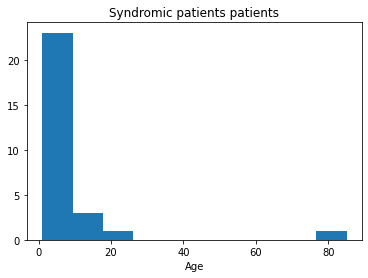

In [37]:
# Make a histogram of all ages

ages_syn = df_syn.age.values
print(len(ages_syn))
plt.hist(ages_syn)
plt.xlabel("Age")
plt.title("Syndromic patients patients")
plt.show()

In [38]:
# open ID control excel sheet
ID_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ID-controls\all_ID_controls_info_complete.xlsm" 

assert os.path.exists(ID_file), "This path doesn't exist."

    
df_ID = pd.read_excel(ID_file)

df_ID = df_ID[['pnummer', 'frontal face image', 'agecorrected', 'gender']]
df_ID = df_ID[df_ID['frontal face image'].notnull()]
df_ID = df_ID.rename(columns={"frontal face image": "image", "agecorrected": "age"})

print(df_ID.shape)
df_ID.sample(4)


(381, 4)


,pnummer,image,age,gender
216,P07-2383,P07-2383_F1_2015Y_.JPG,12,m
55,P03-2443,DSCN0639.JPG,24,m
163,P06-2461,IMG_1067.JPG,4,f
325,P10-1415,P10-1415_F1_.JPG,10,m


In [39]:
# for each entry in KdV df find a matching ID control, save in new pandas dataframe

# empty object
df_select_syn = pd.DataFrame(columns=['Patient', 'age', 'gender'])
df_select_ID = pd.DataFrame(columns=['pnummer', 'image', 'age', 'gender'])

age_dif_list = []
low_age = 0
high_age = 100 # aka all patients, can be adjusted in case of age groups

# find control ID for each syndromic patients
for index, row in df_syn.iterrows():

    age_syn = int(row['age'])
    
    if  low_age <= age_syn <= high_age:
        
        gender_syn = row['gender'].lower()
    
        # find a control ID with exact same age
        matches_ID = df_ID.loc[(df_ID['age'] == age_syn) & (df_ID['gender'] == gender_syn)]
        
        # try different age differences
        age_dif = [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6]
        i = 0   
        while matches_ID.shape[0] == 0:
            matches_ID = df_ID.loc[(df_ID['age'] == age_syn + age_dif[i]) & (df_ID['gender'] == gender_syn)]
            i+= 1
            if i == len(age_dif):
                break

        if(matches_ID.shape[0] ==0):
            print("For patient {}, gender: {}, age: {}".format(row['image'], row['gender'], row['age']))
            print("No match found within {} and {} years".format(max(age_dif), min(age_dif)))
            continue

        age_dif_list.append(age_dif[i])
        
        # a match is found, so append sy patient
        df_select_syn = df_select_syn.append(row) 

        # pick a random control from this list to append to selected controls
        random_index = random.randint(0, matches_ID.shape[0]-1)
        select_ID = matches_ID.iloc[random_index]
        df_select_ID = df_select_ID.append(select_ID)

        # remove selected row from set of all controls 
        i = df_ID[(df_ID.image == select_ID.image) & (df_ID.pnummer == select_ID.pnummer)].index

        OG_shape = df_ID.shape
        df_ID = df_ID.drop(i)
        new_shape = df_ID.shape  
        

        if(OG_shape[0] - new_shape[0]> 1):
            print("Error")

For patient ADNP_39, gender: F, age: 85.0
No match found within 6 and -6 years


In [40]:
print(df_select_syn.shape)
print(df_select_ID.shape)

(27, 4)
(27, 4)


In [41]:
# save information to 2 Excel files
syn_name = "ADNP"
syn_info_save = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}_patients_info.xlsx".format(syn_name, syn_name)
ID_info_save = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}_matched_ID_controls_info.xlsx".format(syn_name, syn_name)
df_select_syn.to_excel(syn_info_save)
df_select_ID.to_excel(ID_info_save)


### Open Excel files and write the found images to a new directory

In [43]:
ID_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ID-controls"
select_ID_dir =  r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-selected-ID-controls".format(syn_name, syn_name)

# open excel file
df_ID = pd.read_excel(ID_info_save)

for index,rows in df_ID.iterrows():
    pnr = rows['pnummer']
    image = rows['image']
    
    files = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ((pnr + "_small_" + image.replace(".JPG", "")) in f))]
    if(len(files)==1):
        im = Image.open(join(ID_dir, files[0]))
        im.save(join(select_ID_dir, files[0]))
    else: 
        print("Manually find image for " + str(pnr) + "_small_" + str(image.replace(".JPG", "")))   
        print("in " + str(ID_dir))


In [45]:
syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-all-photos".format(syn_name, syn_name)
select_syn_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\{}\{}-patients".format(syn_name, syn_name)

df_syn = pd.read_excel(syn_info_save)

for index,rows in df_syn.iterrows():
    image = rows['image']
    files = [f for f in listdir(syn_dir) if (isfile(join(syn_dir, f)) and image + ".jpg" in f)]
    if(len(files)==1):
        im = Image.open(join(syn_dir, files[0]))
        im.save(join(select_syn_dir, files[0]))
    else: 
        print("Manually find image for image: {}".format(image))